# 4.4 共役事前分布の混合

## インポート・設定

In [125]:
import warnings

import pymc as pm
import seaborn as sns
import numpy as np
import arviz as az
from scipy import special

In [126]:
sns.set_theme()
warnings.simplefilter("ignore")
RANDM_STATE = np.random.default_rng(seed=0)

## Introduction: 3.4でやったこと

尤度:

$$
p(y | \theta): \quad
\text{Binomial}(n=43, p=\theta)
$$

事前分布:

$$
p(\theta): \quad
\frac{3}{4} \text{Beta}(2, 8) + \frac{1}{4} \text{Beta}(8, 2)
$$

事後分布:

$$
p(\theta | y): \quad
w_{1} \text{Beta}(2, 8) + w_{2} \text{Beta}(8, 2)
\\
~
\\
\text{where} \quad 
\begin{cases}
w_{1} &= \frac{3 B(17, 36)}{3 B(17, 36) + B(23, 30)} \\
w_{2} &= \frac{B(23, 30)}{3 B(17, 36) + B(23, 30)}
\end{cases}
$$

## a

事後分布 $p(\theta | y)$ をプロットする

In [127]:
def build_posterior_model_a():
    # define PyMC model
    with pm.Model() as model:
        # weights
        w1 = (3 * special.beta(17, 36)) / (
            3 * special.beta(17, 36) + special.beta(23, 30)
        )
        w2 = 1 - w1

        # posterior distribution
        theta = pm.Mixture(
            "theta",
            w=[w1, w2],
            comp_dists=[
                pm.Beta.dist(alpha=17, beta=36),
                pm.Beta.dist(alpha=23, beta=30),
            ],
        )

    return model

theta ~ MarginalMixture(<constant>, Beta(17, 36), Beta(23, 30))

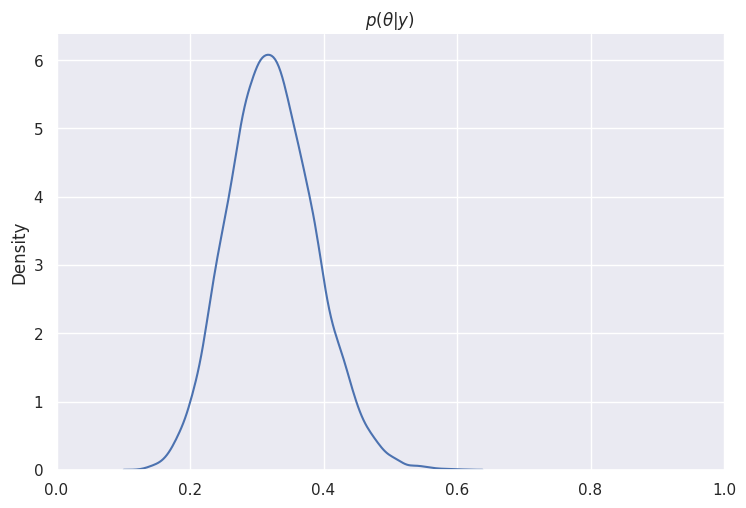

In [128]:
model_a = build_posterior_model_a()
display(model_a)

n_draws = 10_000
theta_posteior_a = pm.draw(model_a.theta, n_draws, random_seed=RANDM_STATE)

_ = sns.displot(
    theta_posteior_a,
    kind="kde",
    aspect=1.5,
).set(title="$p(\\theta|y)$", xlim=(0, 1))

$\theta$ の文に点に基づく95%信用区間を計算する

In [138]:
ci_a = np.quantile(
    theta_posteior_a,
    q=[0.025, 0.975],
)
ci_a

array([0.20441527, 0.45584836])

## b

In [130]:
def build_posterior_model_b():
    # define PyMC model
    with pm.Model() as model:
        # weight
        w = (special.beta(23, 30)) / (3 * special.beta(17, 36) + special.beta(23, 30))

        # x in {0, 1}
        x = pm.Binomial("x", n=1, p=w)

        # theta ~ Beta(17, 36) if x = 0
        # theta ~ Beta(23, 30) if x = 1
        theta = pm.Deterministic(
            "theta",
            pm.math.switch(
                pm.math.eq(x, 0),
                pm.Beta("beta1", alpha=17, beta=36),
                pm.Beta("beta2", alpha=23, beta=30),
            ),
        )
    return model

    x ~ Binomial(1, 0.0151)
beta1 ~ Beta(17, 36)
beta2 ~ Beta(23, 30)
theta ~ Deterministic(f(beta2, beta1, x))

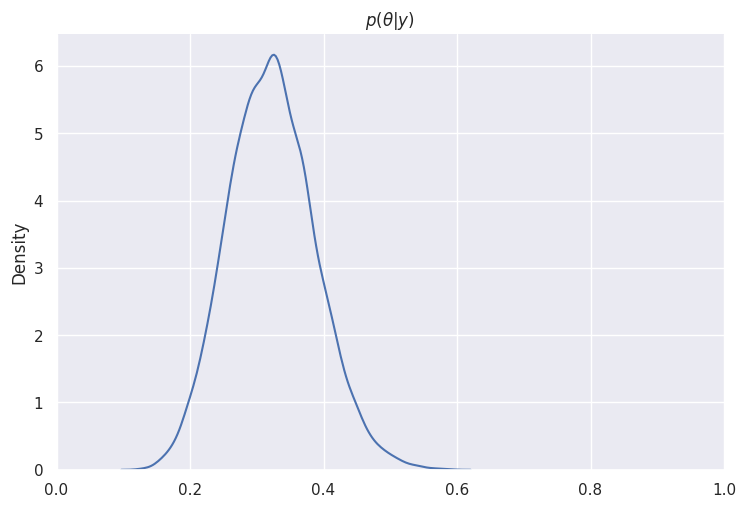

In [131]:
model_b = build_posterior_model_b()
display(model_b)

n_draws = 10_000
theta_posteior_b = pm.draw(model_b.theta, n_draws, random_seed=RANDM_STATE)

_ = sns.displot(
    theta_posteior_b,
    kind="kde",
    aspect=1.5,
).set(title="$p(\\theta|y)$", xlim=(0, 1))

In [139]:
ci_b = np.quantile(
    theta_posteior_b,
    q=[0.025, 0.975],
)
ci_b

array([0.20128259, 0.45602668])

aの結果と比較する

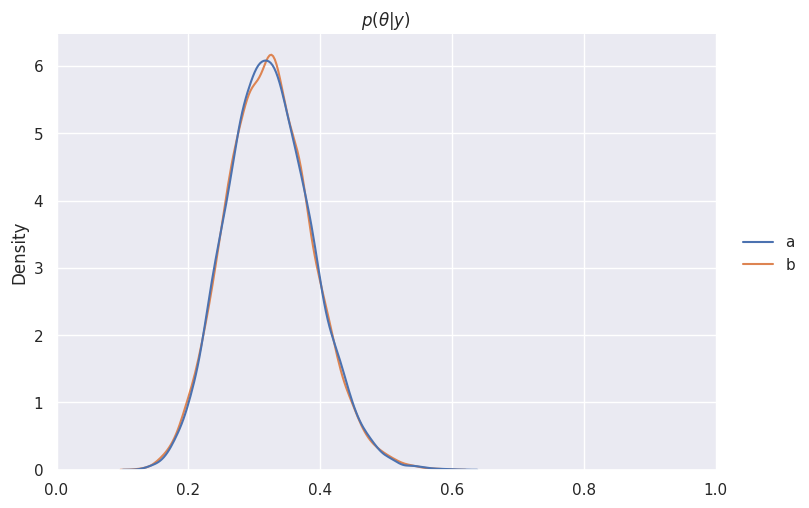

In [133]:
_ = sns.displot(
    {
        "a": theta_posteior_a,
        "b": theta_posteior_b,
    },
    kind="kde",
    aspect=1.5,
    common_norm=False,
).set(title="$p(\\theta|y)$", xlim=(0, 1))

In [143]:
# 95%信用区間
print("a:  ", ci_a)
print("b:  ", ci_b)

a:   [0.20441527 0.45584836]
b:   [0.20128259 0.45602668]


## Appendix: MCMCで事後分布を推定する

MCMCによって事後分布からサンプリングする

In [134]:
def build_mcmc_model():
    with pm.Model() as model:
        # observed data
        n = 43
        y_observed = 15

        # prior
        weights = pm.ConstantData("weights", [0.75, 0.25])
        theta = pm.Mixture(
            "theta",
            w=weights,
            comp_dists=[
                pm.Beta.dist(alpha=2, beta=8),
                pm.Beta.dist(alpha=8, beta=2),
            ],
        )

        # likelihood
        y = pm.Binomial("y", n=n, p=theta, observed=y_observed)

    return model

In [135]:
# PyMCのモデル
model_mcmc = build_mcmc_model()
model_mcmc

theta ~ MarginalMixture(<constant>, Beta(2, 8), Beta(8, 2))
    y ~ Binomial(43, theta)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


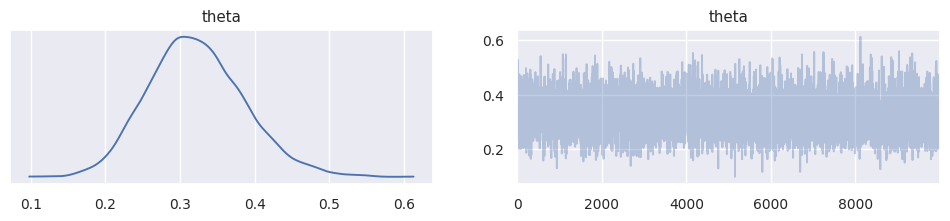

In [136]:
# MCMCによってサンプリングを行う
n_draws = 10_000

with model_mcmc:
    idata = pm.sample(n_draws, chains=1, random_seed=RANDM_STATE)

_ = az.plot_trace(idata)

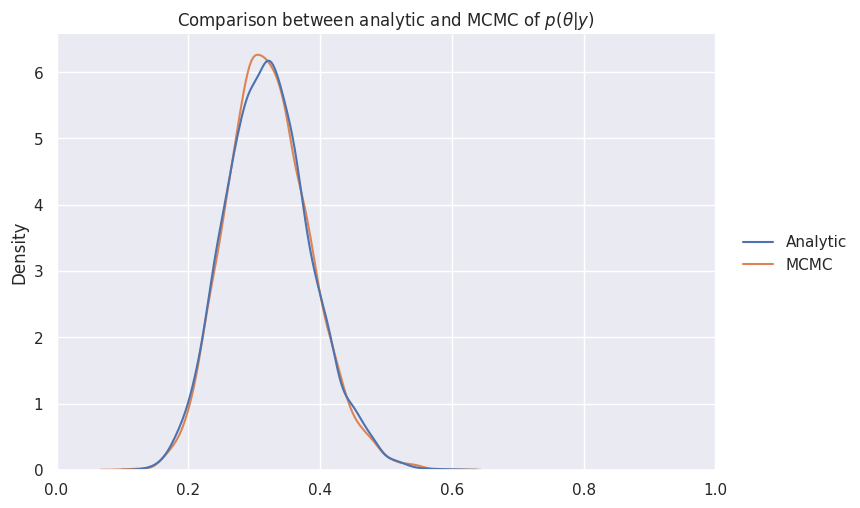

In [137]:
# 解析解の事後分布とMCMCで推定した事後分布を比較する
theta_posteior_mcmc = idata.posterior["theta"].data.ravel()
_ = sns.displot(
    data={
        "Analytic": theta_posteior_a,
        "MCMC": theta_posteior_mcmc,
    },
    kind="kde",
    aspect=1.5,
    common_norm=False,
).set(title="Comparison between analytic and MCMC of $p(\\theta|y)$", xlim=(0, 1))